# Imports, styles, etc

In [2]:
import numpy as np
import pandas as pd
from liwc import Liwc
from matplotlib import pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import scipy
import glob
import re
import yaml
import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

import scipy.stats as stats

filepaths = yaml.safe_load(open("../../../config/filepaths.yaml"))

import sys
sys.path.append(filepaths['utils'])
from data import *
from liwc_utils import *
from analisys import *

In [3]:
plt.rcParams['axes.labelsize']  = 14 # fontes no tamanho usado no template
plt.rcParams['axes.titlesize']  = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.5

plt.style.use('tableau-colorblind10') # use um estilo colorblind!
plt.ion()

---

In [4]:
DATASET = 'twitter' # 'coraal-buckeye' | 'twitter' | 'youtube' | 'interview'

data = load_dataset(DATASET)
data.head(1)

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,group
0,@user wat r u doin boy,0.037538,0.0,0.0,0.0,0.048113,0.014581,0.146005,False,aa_112.csv,aa


# Reading and processing data

In [5]:
#Numero de amostras de cada tipo
data.drop_duplicates('file').groupby('group').count()['text']

group
aa    250
wh    250
Name: text, dtype: int64

In [6]:
# Faz copia dos dados e remove qualquer caracter que não seja textual ou apóstrofo
df = data.copy()
df['text'] = df['text'].apply(lambda x: re.sub("[^\w\d'\s]+",'',x))

In [7]:
# executes a join in column text grouped by file, this will join all the texts and keep group info
text_df = df.groupby('file',as_index=False).agg({
    'text': lambda x: ' '.join(x),
    'group': lambda x: x.iloc[0]
})
text_df.head(3)

,file,text,group
0,aa_1.csv,yea uu did some put dat bx in dere ' ion fuck...,aa
1,aa_10.csv,user at da house i was dwn ridin around nigga ...,aa
2,aa_100.csv,user yea dats more like it b4 i make a trip up...,aa


In [8]:
liwc_parser = Liwc(filepaths['liwc_dict']) # carrega o dicionário e inicializa a classe do LIWC

text_df['liwc_count'] = text_df['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
text_df = text_df.reset_index(drop=True)
text_df.head(3)

,file,text,group,liwc_count
0,aa_1.csv,yea uu did some put dat bx in dere ' ion fuck...,aa,"{'informal': 4, 'netspeak': 2, 'assent': 1, 'f..."
1,aa_10.csv,user at da house i was dwn ridin around nigga ...,aa,"{'function': 6, 'prep': 3, 'relativ': 3, 'spac..."
2,aa_100.csv,user yea dats more like it b4 i make a trip up...,aa,"{'informal': 2, 'netspeak': 2, 'assent': 1, 'a..."


---

# Processing data with LIWC

In [9]:
# create a new dataset where the dicts inside liwc_cont are expanded in columns
liwc_df = pd.concat([text_df.drop(['liwc_count'], axis=1), text_df['liwc_count'].apply(pd.Series)], axis=1)
liwc_df = liwc_df.fillna(0)

#normalizing 
liwc_df_norm = (liwc_df[liwc_parser.categories.values()].T * ( 1 / liwc_df[liwc_parser.categories.values()].sum(axis=1) )).T
liwc_df_norm.reset_index(drop=True,inplace=True)

liwc_df_norm['group'] = text_df['group']
liwc_df_norm = liwc_df_norm.fillna(0)
liwc_df_norm.head(3)

,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,...,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,group
0,0.058824,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.00000,...,0.0,0.0,0.0,0.117647,0.029412,0.058824,0.029412,0.029412,0.0,aa
1,0.181818,0.030303,0.030303,0.030303,0.0,0.0,0.0,0.0,0.00000,0.00000,...,0.0,0.0,0.0,0.060606,0.030303,0.030303,0.000000,0.000000,0.0,aa
2,0.156250,0.062500,0.031250,0.031250,0.0,0.0,0.0,0.0,0.03125,0.03125,...,0.0,0.0,0.0,0.062500,0.000000,0.062500,0.031250,0.000000,0.0,aa


---

## Kruscal-Wallis Test

In [10]:
experiments = []
old_experiments = []

for feature in liwc_parser.categories.values():
    
    result = stats.kruskal(
        liwc_df_norm[liwc_df_norm.group=='aa'][feature],
        liwc_df_norm[liwc_df_norm.group=='wh'][feature],
    )
    experiments.append({
        'feature': feature,
        'statistic': result[0],
        'pvalue': result[1]
    })
experiments = pd.DataFrame(experiments)

## Relevant features

https://www.liwc.net/LIWC2007LanguageManual.pdf

https://repositories.lib.utexas.edu/bitstream/handle/2152/31333/LIWC2015_LanguageManual.pdf

In [11]:
import statsmodels.stats.multitest as smt
idx = smt.multipletests(pvals=experiments.pvalue, alpha=0.01, method="bonferroni")[0]
print(len(experiments[idx].sort_values('pvalue')))
experiments[idx].sort_values('pvalue')

5


,feature,statistic,pvalue
67,informal,112.648283,2.576562e-26
69,netspeak,85.333374,2.520727e-20
68,swear,50.624003,1.118685e-12
0,function,28.240421,1.071435e-07
60,time,18.751540,1.489031e-05


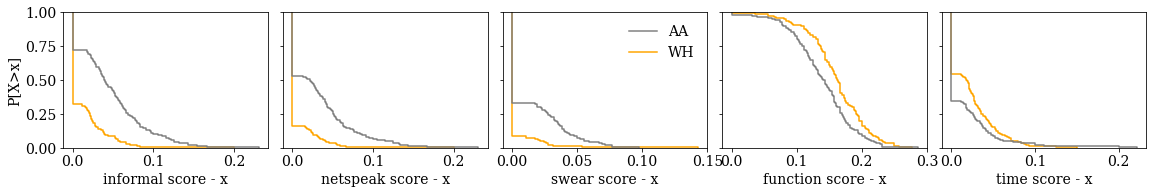

In [14]:
plot_liwc_features(
    liwc_df_norm, 
    ploting_vars=['informal','netspeak','swear', 'function', 'time'],
    hue_order=['aa','wh'],
    legend_labels = ['AA', 'WH'],
    palette=['grey','orange',]
)

# individual categories analisys

### calculating liwc per sentence

In [15]:
scores_liwc = df.copy()

scores_liwc['liwc_count'] = scores_liwc['text'].apply(liwc_sentence_parse, args=(liwc_parser,)) #aplica do liwc
scores_liwc['len'] = scores_liwc.text.str.split(' ').str.len()
scores_liwc = scores_liwc.reset_index().rename(columns={'index':'sentence_id'})
scores_liwc = pd.concat([scores_liwc.drop(['liwc_count'], axis=1), scores_liwc['liwc_count'].apply(pd.Series)], axis=1)
scores_liwc = scores_liwc.fillna(0)
scores_liwc.head(1)

,sentence_id,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,...,body,money,hear,friend,family,motion,sexual,we,relig,number
0,0,user wat r u doin boy,0.037538,0.0,0.0,0.0,0.048113,0.014581,0.146005,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### KS test and bonferroni correction - For liwc categories scored

In [16]:
liwc_toxicity_experiments = []
for score in [col for col in scores_liwc.columns if 'score' in col]:
    for feature in liwc_parser.categories.values():
        if (len(scores_liwc[scores_liwc[feature]==0]) == 0 
                and len(scores_liwc[scores_liwc[feature]>0] == 0)):
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': np.nan,
                'pvalue': np.nan,
                'score': score
            })
        else:
            result = stats.ks_2samp(
                scores_liwc[scores_liwc[feature]==0][score],
                scores_liwc[scores_liwc[feature]>0][score]
            )
            liwc_toxicity_experiments.append({
                'feature': feature,
                'statistic': result[0],
                'pvalue': result[1],
                'score': score
            })

liwc_toxicity_experiments = pd.DataFrame(liwc_toxicity_experiments)
liwc_toxicity_experiments.sort_values('pvalue')

,feature,statistic,pvalue,score
242,negemo,0.787057,1.098180e-73,vader_score
23,negemo,0.487332,8.165791e-25,perspective_score
359,informal,0.442088,9.007111e-23,detoxify_original_score
315,negemo,0.460359,4.808573e-22,detoxify_original_score
461,negemo,0.451188,3.792534e-21,detoxify_multilingual_score
...,...,...,...,...
122,affiliation,0.000000,1.000000e+00,flair_score
180,cause,0.000000,1.000000e+00,textblob_score
121,drives,0.000000,1.000000e+00,flair_score
169,negemo,0.000000,1.000000e+00,textblob_score


In [17]:
#seleciona as categorias em que todos scores são estatisticamente diferentes (p-value < 0.01)
#TODO: Bonferroni correction

relevant_categories_by_toxicity = liwc_toxicity_experiments.iloc[
    liwc_toxicity_experiments.groupby('feature').agg({
        'pvalue': lambda x: x.idxmax(),
    })['pvalue']
].query('pvalue < 0.01').feature.unique()

relevant_categories_by_toxicity

array([], dtype=object)

---
# Associating categories frequencies with toxicity

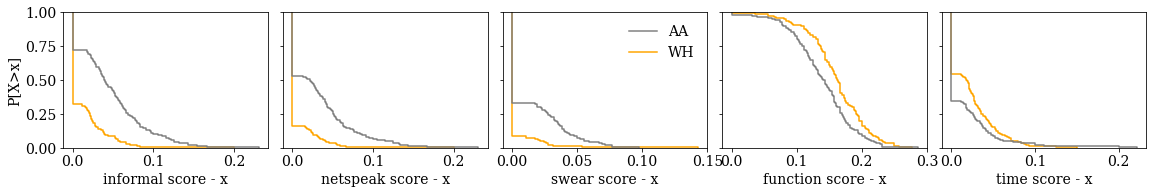

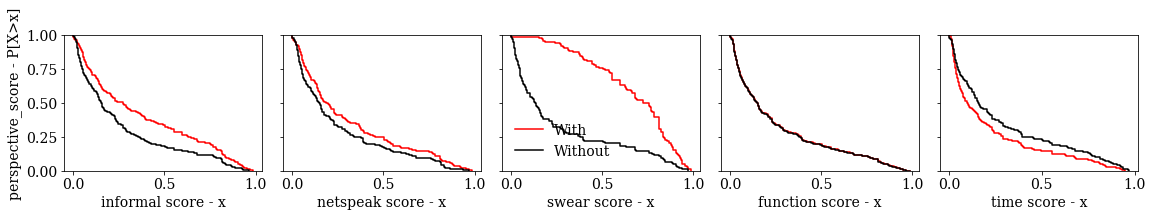

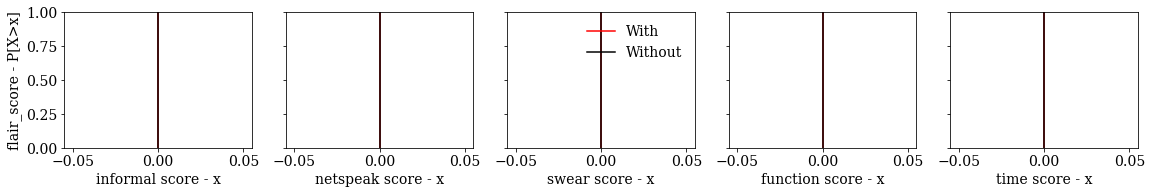

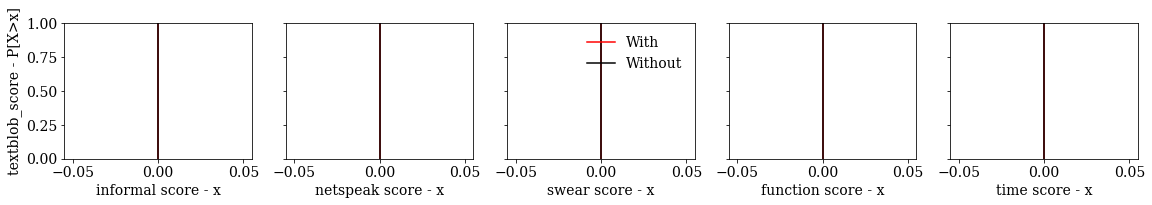

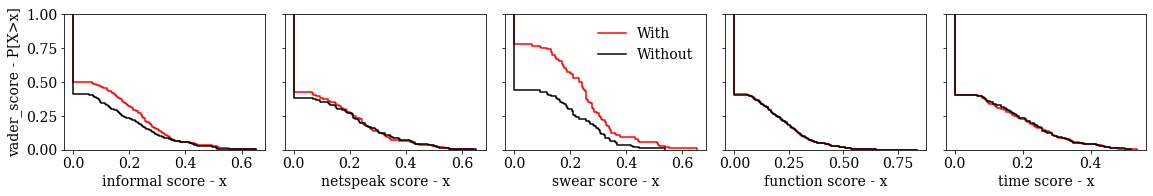

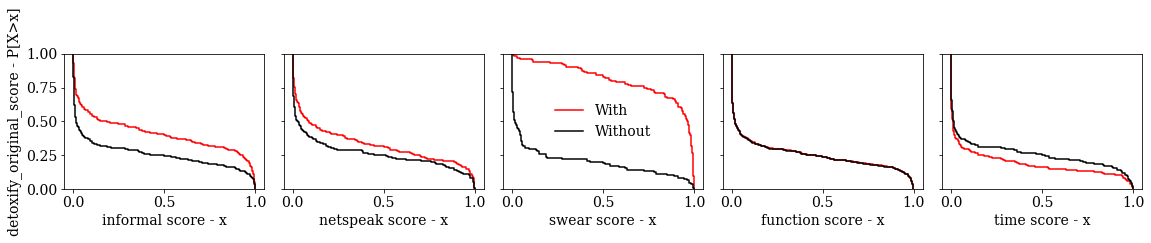

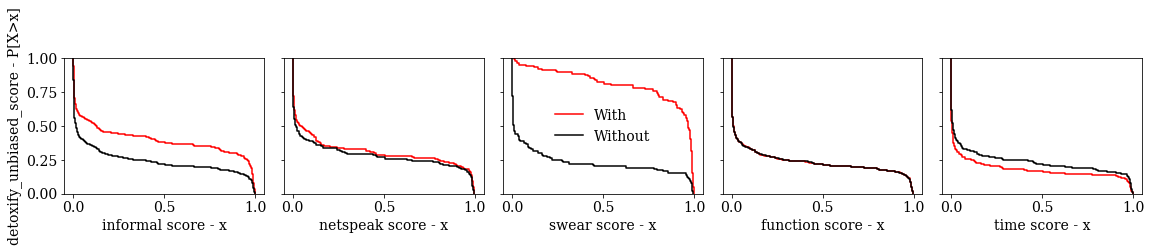

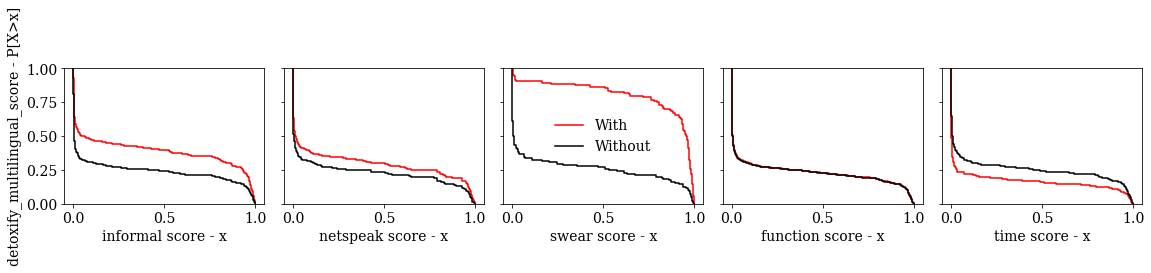

In [20]:
# TODO: nos graficos de score (with e without) usar distribuições com o 
# mesmo numero de sentenças de pretos e brancos, homem e mulher, no momento, 
# nenhuma das formas considera um numero de amostras igual por genero e raça


# analisa i a i de 5 em 5 categorias as categorias que são estatisticamente diferentes obtidas 
# na analise anterior e plota suas frequencias e seus scores
# i = 0
# i += 5
ploting_vars=['informal','netspeak','swear', 'function', 'time']
# #list(experiments[experiments.feature.isin(relevant_categories_by_toxicity)].sort_values('pvalue').iloc[i:i+5].feature)

plot_liwc_features(
    liwc_df_norm,
    ploting_vars=ploting_vars,
    hue_order=['aa','wh'],
    legend_labels = ['AA', 'WH'],
    palette=['grey','orange',]
)
plot_liwc_scored(scores_liwc,ploting_vars,scores=scores_liwc.columns,comparative_behaviour='same_sz_sample')

---

# Avg. words per video

In [21]:
scores_liwc.groupby(['file','group']).sum()[['len']].reset_index().groupby('group').mean()

,len
group,
aa,12.288
wh,14.096
